In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Libraries and Filesystem Setup

In [2]:
import pandas as pd
import pickle
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse

### Import Doc2Vec document vectors

In [3]:
dv_matrix = np.load(open("../processed_files/dv_matrix.npy", "rb"), allow_pickle=True)
df_merged = pickle.load(open("../processed_files/df_merged.pickle", "rb"))

In [4]:
print(dv_matrix.shape)
print(dv_matrix[0].shape)

(12956, 300)
(300,)


In [5]:
#dv_mat = np.load('../processed_files/dv_matrix.npy', allow_pickle = True)

In [6]:
dv_matrix[0]

array([ 0.03604639,  0.13157497, -0.15107524,  0.04952792,  0.10527853,
       -0.17297259, -0.06993171,  0.40140012, -0.3131112 , -0.10516197,
       -0.15801504, -0.06474262,  0.06297238, -0.16530246, -0.32713166,
       -0.01795422,  0.01369349, -0.01286896,  0.06122278,  0.3125197 ,
       -0.16601239, -0.3649068 , -0.16268912,  0.08684894, -0.21271873,
       -0.14799328, -0.07843824,  0.19604656, -0.16349131,  0.21223599,
       -0.3285773 , -0.1741543 ,  0.4267438 ,  0.20463504,  0.12851113,
       -0.04915418,  0.10453223,  0.02351662,  0.48286504,  0.1685224 ,
        0.1201156 , -0.06911872,  0.0330828 , -0.11538547,  0.61140984,
       -0.0829362 , -0.01042583,  0.16370074,  0.08389823,  0.1815935 ,
       -0.03590801,  0.01826324, -0.10699306,  0.13231613, -0.35821298,
        0.3702536 , -0.0377877 ,  0.16298805,  0.0118171 ,  0.24093275,
       -0.21661487,  0.1680813 ,  0.02111592,  0.00080282, -0.28270203,
        0.00504151,  0.00791699, -0.20062318, -0.37629476,  0.18

In [7]:
#dv_mat = np.matrix(dv_mat.tolist())
#dv_mat

In [8]:
#for i in range(len(dv_mat)):
#    try:
#        #print(type(dv_matrix[i])
#        len(dv_matrix[i])
#    except:
#        dv_mat[i] = np.asmatrix(np.zeros(300))

## doc2vec

In [9]:
from sklearn.preprocessing import normalize
dv_mat = normalize(dv_matrix, norm='l2', axis=1)

In [10]:
%%time
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(dv_mat)
distances, indices = nbrs.kneighbors(dv_mat)

CPU times: user 1min 20s, sys: 104 ms, total: 1min 20s
Wall time: 1min 21s


In [75]:
print(distances.shape)
print(indices.shape)

(12956, 20)
(12956, 20)


In [76]:
distances[0]

array([0.        , 0.25809519, 0.27388345, 0.27495014, 0.275294  ,
       0.27649198, 0.27698166, 0.27805731, 0.27874369, 0.27936859,
       0.28115546, 0.28123149, 0.28367055, 0.28416784, 0.28609574,
       0.28655612, 0.28894667, 0.29128302, 0.29131243, 0.29136885])

In [77]:
indices[0]

array([    0,  4027,  3925,  9761,  7570,  4965,  8721,  4399,  3211,
        9198, 12206, 10045,  1963,  4119,  4786,  4736,  2245,  4002,
        2072, 12377])

In [126]:
import statistics

def intracluster_similarity(index):
    cluster_centroid = dv_mat[index]
    dist_list = []
    for i in indices[index][1:]:
        distance = np.linalg.norm(cluster_centroid-dv_mat[i])
        dist_list.append(distance)
        
    #avg = sum_dist/(len(indices[index])-1)
    avg = np.average(dist_list)

    #variance = statistics.variance(dist_list)
    variance = np.var(dist_list)
    
    return avg, variance

In [127]:
intracluster_similarity(0)

(0.28092918, 6.073953e-05)

In [80]:
def generate_raw_content_cluster_df(index):
    index_list = list(indices[index])
    distance_list = list(distances[index])
    cluster_seed = df_merged.loc[index].to_frame().T
    cluster_seed['DISTANCE'] = 0
    cluster_df = df_merged.loc[index_list[1:]]
    cluster_df['DISTANCE'] = distance_list[1:]
    combined = pd.concat([cluster_seed, cluster_df.sort_values(by='DISTANCE', ascending=True)])
    return combined.style.set_properties(subset=['RAW_CONTENT'], **{'width-min': '100px'})
    #return combined

In [83]:
# non-unique index errors
# 14 is a good example
# 21 can we stop output after distance goes from 3 to 10.583?
# 22 is lots of similar basic e
generate_raw_content_cluster_df(393)

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PARSED,DISTANCE
393,ahistoryofnewyork.com,"patell and waterman's history of new york | being a ... course, companion, blog, and book. select page by | sep 20, 2015 | , bryan and i had the good fortune last week to be able to hear the visionary kronos quartet twice each during their week-long residence at nyu abu dhabi where we’re presently teaching. the ensemble played at nyuad arts center’s black box... by | nov 22, 2014 | , the good folks at genius.com asked me to annotate a passage from my 33 1/3 volume on television’s marquee moon. here’s what i came up with: read by | oct 23, 2014 | , , friends of our too-long moribund writing new york site, i hope you’ll come say hello while i’m in town, briefly, to participate in the following event, which draws on a new research project i’ve undertaken re: new york in the age of warhol. andy... by | mar 17, 2014 | , , , in march 1974, a band called television by | oct 29, 2013 | , , so it’s just about three days since lou reed died and i admit i’m kind of holding my breath, waiting to see if he rises from the tomb on the morning of the third day. it’s hard to imagine him as anything other than transformed into a more perfect... by | oct 19, 2013 | two years ago, we ran a virtual book club by | sep 30, 2013 | , in anticipation of the nyuad theater program and theater mitu’s presentation of md (or, the whale) later this week, the program in literature and creative writing is sponsoring a marathon reading of novel, which the play takes as its inspiration. the reading... by | sep 12, 2013 | , one of the great delights of the decade cyrus and i spent teaching our writing new york class was the repeated opportunity to screen clips from ric burns’s monumental new york: a documentary film. without a doubt, the highlight of that film is — for me, at... by | sep 9, 2013 | , today’s installment in our discussion of teju cole’s novel comes from guest blogger martha nadell, who teaches at brooklyn college and is at work on a literary history of brooklyn. the author of a book on image and text in early twentieth-century african... by | sep 4, 2013 | , today’s installment in our book club discussion comes from long-time friend-of-the-blog sunny stalter, an associate professor in the english department at auburn university. her research examines technology in american literature and culture. her book,... search for: featured posts our sites recent posts recent comments on on on on on on on categoriescategories select category architecture art books city on stage conferences cultural history events exhibitions fashion film food history lost new york microblogging music neighborhood scenes networked new york new york sports odds and ends out and about people politics pop culture port of new york resources signs of the times sports teaching television this day in new york history uncategorized writing new york archives archives select month september 2015 november 2014 october 2014 march 2014 october 2013 september 2013 august 2013 march 2013 february 2013 january 2013 december 2012 november 2012 october 2012 september 2012 august 2012 july 2012 june 2012 may 2012 april 2012 march 2012 february 2012 january 2012 december 2011 november 2011 october 2011 september 2011 august 2011 july 2011 june 2011 may 2011 april 2011 march 2011 february 2011 january 2011 december 2010 november 2010 october 2010 september 2010 august 2010 july 2010 june 2010 may 2010 april 2010 march 2010 february 2010 january 2010 december 2009 november 2009 october 2009 september 2009 august 2009 july 2009 june 2009 may 2009 april 2009 march 2009 february 2009 january 2009 december 2008 november 2008 october 2008 september 2008 august 2008 july 2008 june 2008 may 2008 april 2008 march 2008 february 2008 january 2008 december 2007 november 2007 october 2007 september 2007 keys to the city sites we like meta designed by | powered by","patell and waterman's history of new york | being a ... course, companio

In [145]:
avg_list = []
variance_list = []

for i in range(dv_mat.shape[0]):
    avg, variance = intracluster_similarity(i)
    avg_list.append(avg)
    variance_list.append(variance)
    #print()

([<matplotlib.axis.XTick at 0x1424a82b0>,
 <a list of 11 Text xticklabel objects>)

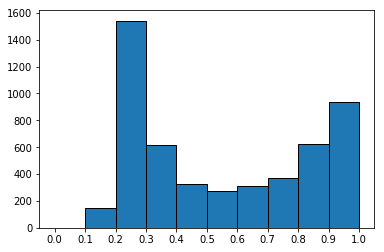

In [146]:
# neighbors = 10
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(avg_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x142466b38>,
 <a list of 11 Text xticklabel objects>)

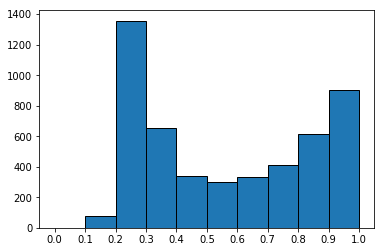

In [129]:
# neighbors = 20
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(avg_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x1420c3208>,
 <a list of 11 Text xticklabel objects>)

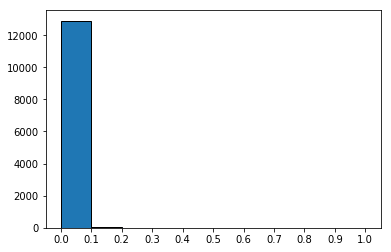

In [147]:
# neighbors = 10
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(variance_list, bins=bins, edgecolor="k")
plt.xticks(bins)

([<matplotlib.axis.XTick at 0x1421b8550>,
 <a list of 11 Text xticklabel objects>)

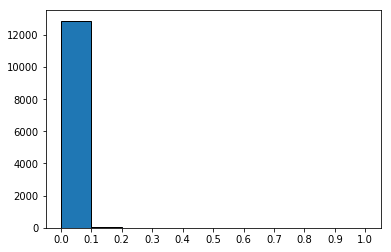

In [130]:
# neighbors = 20
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(variance_list, bins=bins, edgecolor="k")
plt.xticks(bins)

In [18]:
print(len(avg_list), len(variance_list))

12949

## Intercluster Similarity

In [134]:
def calculate_centroid(index):
    cluster_centroid = dv_mat[index]
    for i in indices[index][1:]:
        cluster_centroid = np.add(cluster_centroid, dv_mat[i])
    return cluster_centroid/len(indices[index][1:])

In [148]:
index_centroid = dict()
for i in range(dv_mat.shape[0]):
    index_centroid[i] = calculate_centroid(i)

In [136]:
index_centroid[0]

array([ 1.28414758e-04, -2.08522659e-02,  8.54330361e-02,  2.46596485e-02,
        1.13146575e-02,  3.08373626e-02,  1.98179819e-02, -7.40225092e-02,
       -9.57031921e-02, -4.81029265e-02,  1.02208689e-01, -4.08956483e-02,
        1.87641643e-02,  9.00758877e-02, -1.82558876e-02,  5.13871200e-02,
        1.17934877e-02, -3.27849388e-02,  3.05435248e-03, -5.00569269e-02,
       -6.96634501e-02, -6.04096204e-02, -6.14010803e-02, -8.40272754e-02,
        1.03784181e-01,  4.48104888e-02, -1.39390556e-02, -4.43885028e-02,
        9.97580886e-02, -2.17618942e-02, -8.11996758e-02, -1.14581885e-03,
       -6.39794916e-02,  4.46968228e-02,  1.15394630e-02, -1.71768423e-02,
       -1.75368246e-02, -9.62024108e-02,  2.32559815e-02,  6.55947626e-02,
        1.16894536e-01,  7.17528164e-02,  2.96825427e-03,  7.94791877e-02,
        6.76064566e-02,  3.42977680e-02,  6.48518512e-03, -3.18209343e-02,
       -1.80143937e-02, -1.70408580e-02, -1.91577617e-02,  2.35039145e-02,
        4.86574247e-02, -

In [24]:
#centroid_centroid_distance = {}
#for i in range(dv_mat.shape[0]):
#    centroid_centroid_distance[i] = {}
#    for j in range(dv_mat.shape[0]):
#        if i < j:
#            centroid_centroid_distance[i][j] = np.linalg.norm(index_centroid[i]-index_centroid[j])

In [25]:
#centroid_centroid_distance

In [139]:
from random import sample
def sample_mean_intercluster_dist(sample_size):
    indices_sample = sample(range(dv_mat.shape[0]),sample_size)
    centroid_centroid_distance = {}
    for i in indices_sample:
        for j in indices_sample:
            if i < j:
                key = str(i) + "::" + str(j)
                centroid_centroid_distance[key] = np.linalg.norm(index_centroid[i]-index_centroid[j])
    return np.array(list(centroid_centroid_distance.values())).mean()

# neighbors = 10

## 10 documents sample

In [149]:
sample_10_data = [sample_mean_intercluster_dist(10) for i in range(5)]
print(sample_10_data)
print()
print(np.average(sample_10_data))

[0.6164917, 0.5153907, 0.6736452, 0.47853005, 0.598818]

0.57657516


## 100 documents sample

In [150]:
sample_100_data = [sample_mean_intercluster_dist(100) for i in range(5)]
print(sample_100_data)
print()
print(np.average(sample_100_data))

[0.56610596, 0.60592026, 0.5784322, 0.62448066, 0.6017158]

0.59533095


## 500 documents sample

In [151]:
sample_500_data = [sample_mean_intercluster_dist(500) for i in range(5)]
print(sample_500_data)
print()
print(np.average(sample_500_data))

[0.5762318, 0.60566944, 0.59359497, 0.5925135, 0.588205]

0.59124297


# neighbors = 20

## 10 documents sample

In [140]:
sample_10_data = [sample_mean_intercluster_dist(10) for i in range(5)]
print(sample_10_data)
print()
print(np.average(sample_10_data))

[0.44116002, 0.45280504, 0.59016997, 0.4076249, 0.3117897]

0.44070992


## 100 documents sample

In [141]:
sample_100_data = [sample_mean_intercluster_dist(100) for i in range(5)]
print(sample_100_data)
print()
print(np.average(sample_100_data))

[0.4688207, 0.43424538, 0.4026276, 0.42618105, 0.4686674]

0.4401084


## 500 documents sample

In [142]:
sample_500_data = [sample_mean_intercluster_dist(500) for i in range(5)]
print(sample_500_data)
print()
print(np.average(sample_500_data))

[0.43513295, 0.45055667, 0.45079657, 0.44550946, 0.45433947]

0.447267
